In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim

import torch.nn.functional as F
import os
import wandb

#### <font color="purple"> Hyper parameters 

In [2]:
batch_size = 1
embedding_dim = 128
lr = 0.0001
n_epochs = 150
num_layers = 1
seq_len = 30

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#### <font color="yellow"> Extract all classes 

In [4]:
from load_data import load_data

In [5]:
train_dataset, seq_len, n_features, val_dataset, test_normal_dataset, test_anomaly_dataset, data = load_data(batch_size, seq_len)

Original shape: (84943, 132)
Truncated shape: (84930, 132)
Reshaped shape: (2831, 30, 132)


Original shape: (69659, 132)
Truncated shape: (69630, 132)
Reshaped shape: (2321, 30, 132)
Original shape: (82708, 132)
Truncated shape: (82680, 132)
Reshaped shape: (2756, 30, 132)
Original shape: (96158, 132)
Truncated shape: (96150, 132)
Reshaped shape: (3205, 30, 132)
Original shape: (89883, 132)
Truncated shape: (89880, 132)
Reshaped shape: (2996, 30, 132)
Original shape: (94611, 132)
Truncated shape: (94590, 132)
Reshaped shape: (3153, 30, 132)
Original shape: (88956, 132)
Truncated shape: (88950, 132)
Reshaped shape: (2965, 30, 132)
n_seq:  2520
seq_len:  30
n_features:  132
------------------
n_seq:  298
seq_len:  30
n_features:  132
------------------
n_seq:  147
seq_len:  30
n_features:  132
------------------
n_seq:  17262
seq_len:  30
n_features:  132
------------------


#### <font color="yellow"> Encoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim, num_layers):
        # change embedding_dim from 64 to 32
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim
        self.num_layers = num_layers

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=self.num_layers,
            batch_first=True
        )

    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n[-1]
    

#### <font color="yellow"> Decoder

In [7]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim, n_features, num_layers):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features
        self.num_layers = num_layers

        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((x.size(0), self.seq_len, self.hidden_dim))
        return self.output_layer(x)


#### <font color="yellow"> Seq2Seq Model


In [8]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim, num_layers,device=None):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim, num_layers).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features, num_layers).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
# Define Model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecurrentAutoencoder(seq_len, n_features, embedding_dim, num_layers, device=device)
model = model.to(device)

In [35]:
print(model)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(132, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=132, bias=True)
  )
)


#### <font color="yellow"> Train Model

In [36]:
import wandb
import numpy as np
import copy

def train_model(model, train_dataset, val_dataset, n_epochs, device, lr, early_stopping_patience=10):
    with wandb.init(project="Autoencoder for MediaPipe Landmarks", config={"epochs": n_epochs,}):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.L1Loss(reduction='sum').to(device)
        history = dict(train=[], val=[])
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = 10000.0

        for epoch in range(1, n_epochs + 1):
            model.train()
            train_losses = []

            for seq_true in train_dataset:
                optimizer.zero_grad()
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            val_losses = []
            model.eval()
            with torch.no_grad():
                for seq_true in val_dataset:
                    seq_true = seq_true.to(device)
                    seq_pred = model(seq_true)
                    loss = criterion(seq_pred, seq_true)
                    val_losses.append(loss.item())

            train_loss = np.mean(train_losses)
            val_loss = np.mean(val_losses)
            history['train'].append(train_loss)
            history['val'].append(val_loss)

            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
            wandb.log({"val_loss": val_loss, "train_loss": train_loss})

            if epochs_no_improve >= early_stopping_patience:
                print("Early stopping")
                break

        model.load_state_dict(best_model_wts)
        return model.eval(), history

    wandb.finish()

In [41]:
# Start Training
model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=n_epochs,
    device=device,
    lr=lr,
    early_stopping_patience=10  # Adjust this value as needed
)

Epoch 1: train loss 15.8491847330931 val loss 16.61190710345104
Epoch 2: train loss 15.844853940653422 val loss 16.42499595040443
Epoch 3: train loss 15.79432696570795 val loss 16.240625732963785
Epoch 4: train loss 15.760555209873845 val loss 16.224849824137337
Epoch 5: train loss 15.765319446028856 val loss 16.202029283148065
Epoch 6: train loss 15.737062249234114 val loss 16.47153426016737
Epoch 7: train loss 15.686357762384667 val loss 16.392057903661023
Epoch 8: train loss 15.647374682767051 val loss 16.121830700761254
Epoch 9: train loss 15.652062932587175 val loss 16.249240186657147
Epoch 10: train loss 15.626110640089347 val loss 15.965770394476735
Epoch 11: train loss 15.579285447118144 val loss 15.799494871357144
Epoch 12: train loss 15.5395992096139 val loss 16.053386849845015
Epoch 13: train loss 15.503557718493951 val loss 15.995082837089862
Epoch 14: train loss 15.482123743037068 val loss 16.269338165620297
Epoch 15: train loss 15.447428275668432 val loss 15.9159010587389

train_loss,███▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
val_loss,█▇▇▆▆▆▆▆▆▅▅▄▄▄▄▅▄▄▅▃▄▄▃▃▃▂▄▃▃▃▂▂▃▂▃▂▁▂▂▁
train_loss,13.31568
val_loss,13.93905


In [42]:
torch.save(model, "model_150_plus_123.pth")

#### <font color="yellow"> Validate Model

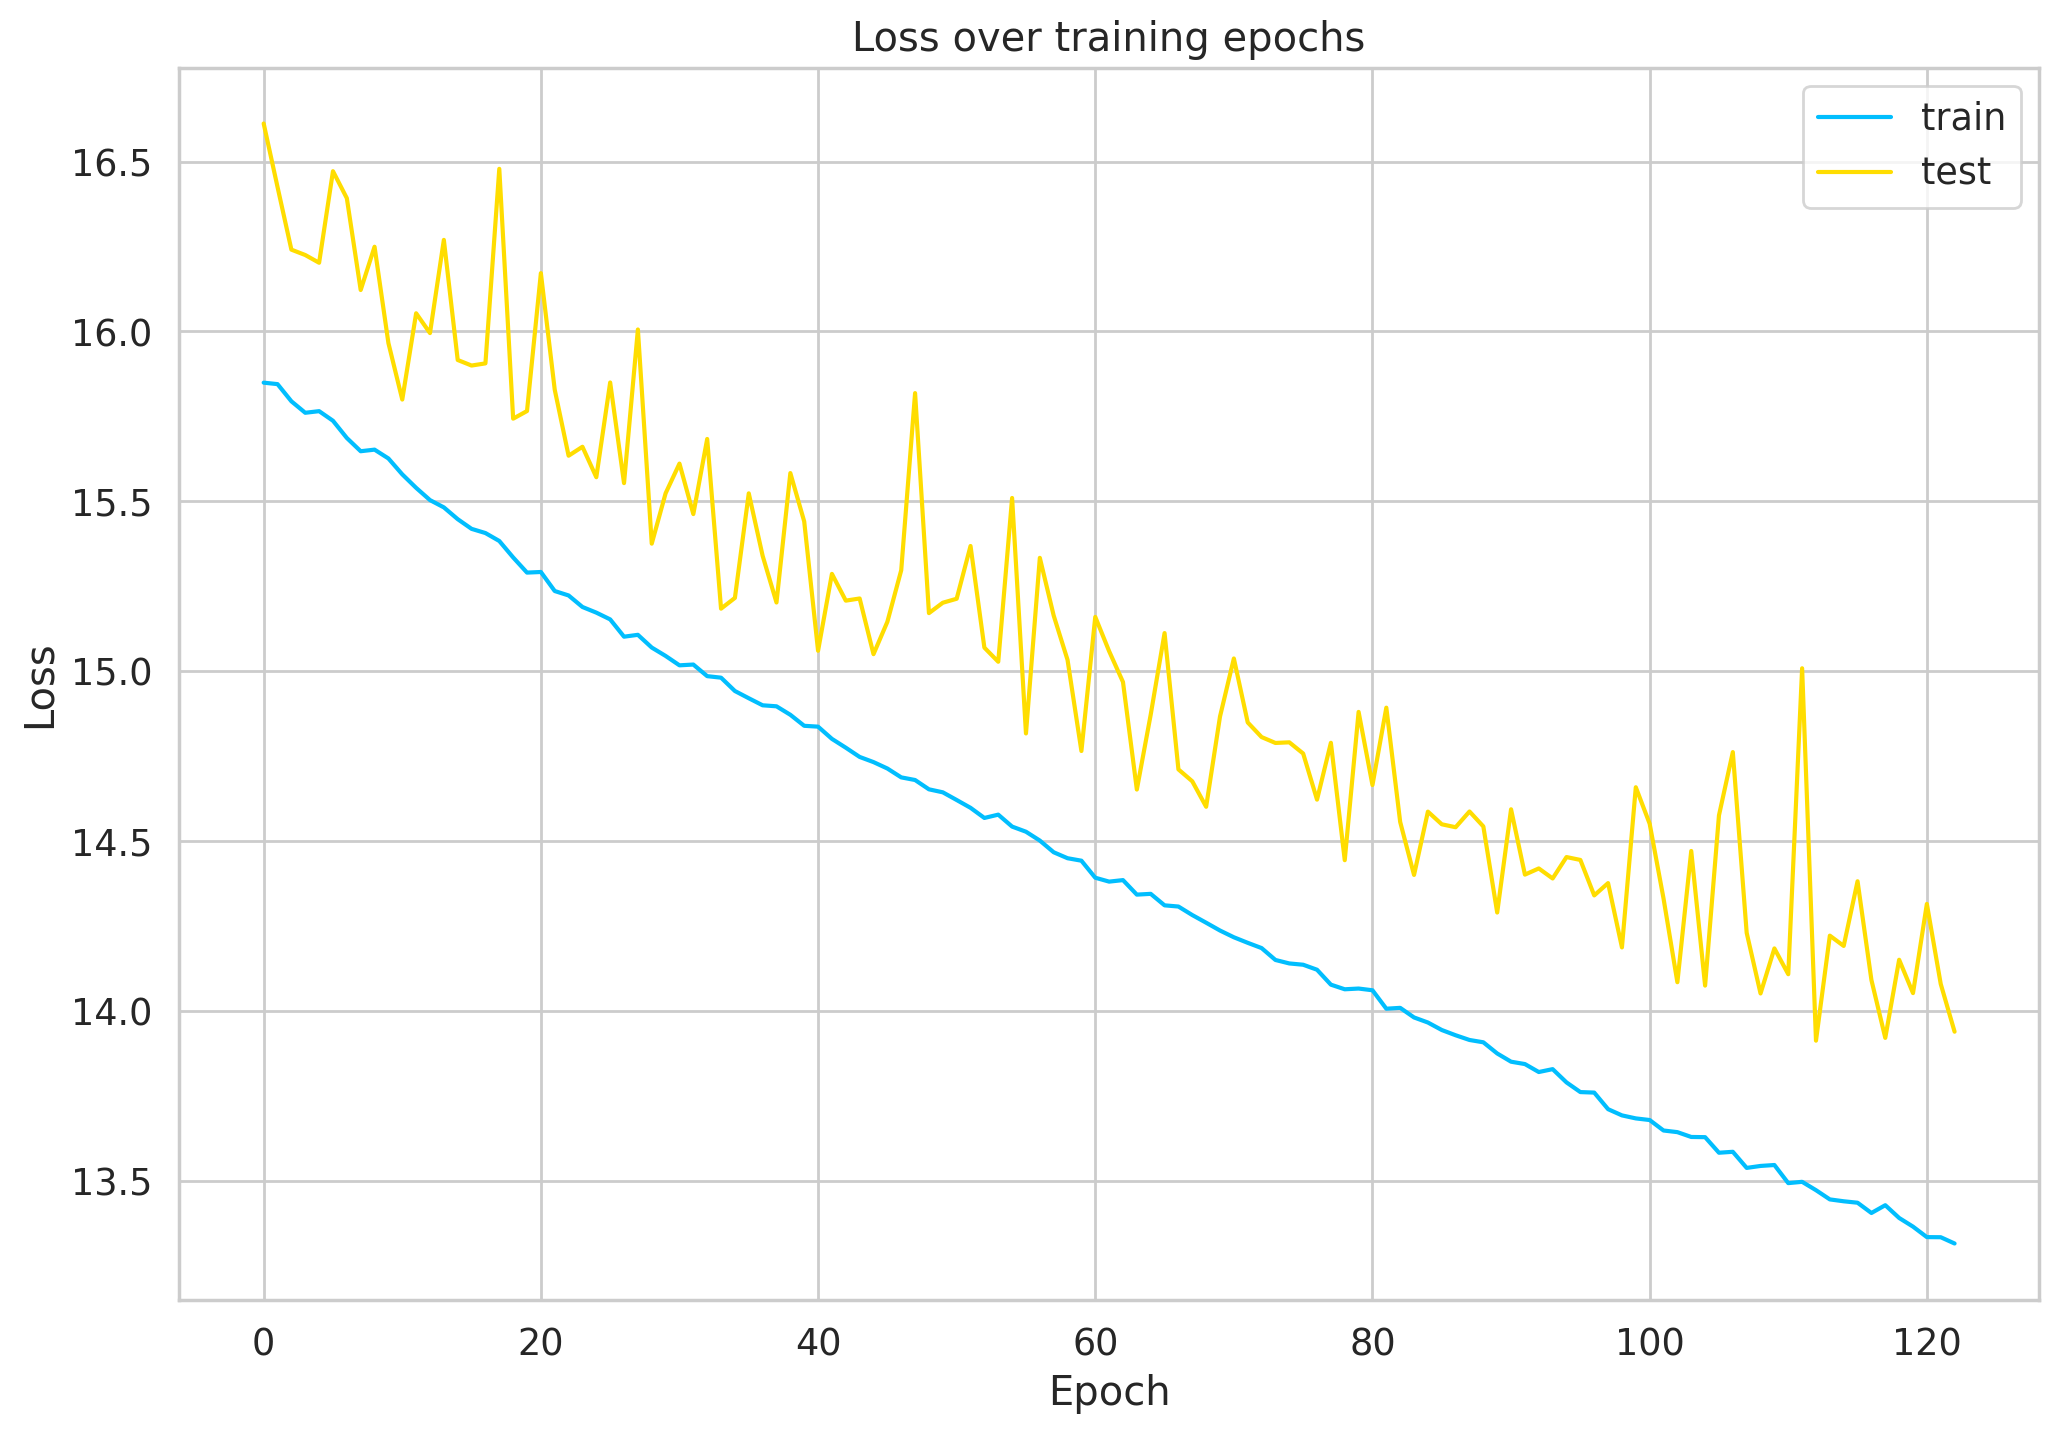

In [43]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

In [63]:
# Save model
MODEL_PATH = 'model_150_plus123.pth'
torch.save(model, MODEL_PATH)

#### <font color="yellow"> Make Predictions & chose Threshold

In [10]:
# Hyper parameters
batch_size = 1
embedding_dim = 128
lr = 0.0001
n_epochs = 150
num_layers = 1
seq_len = 30

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecurrentAutoencoder(seq_len, n_features, embedding_dim, num_layers, device=device)
model.load_state_dict(torch.load('1_128_0.0001_150_1_30.pth'))
model = model.to(device)

In [12]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses


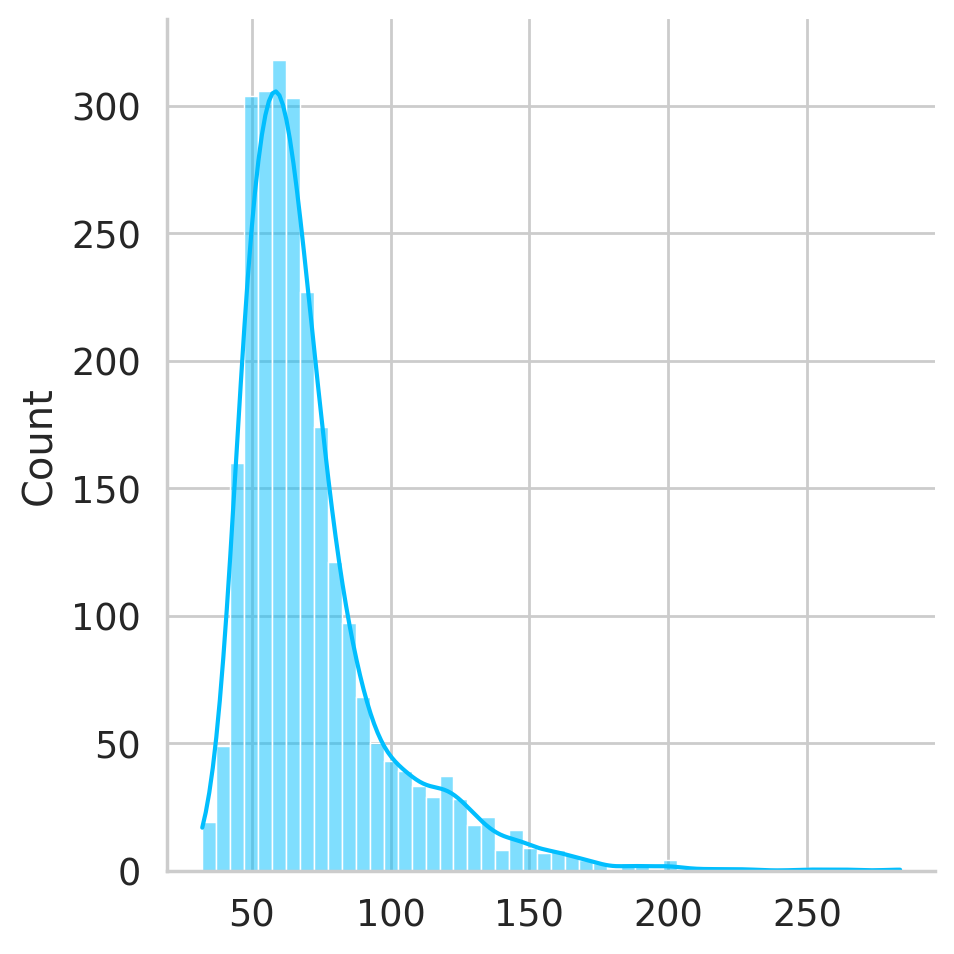

In [13]:
_, losses = predict(model, train_dataset)
sns.displot(losses, bins=50, kde=True)

In [14]:
THRESHOLD = 100

#### <font color="yellow"> Test Normal Data

Correct normal predictions: 103/147


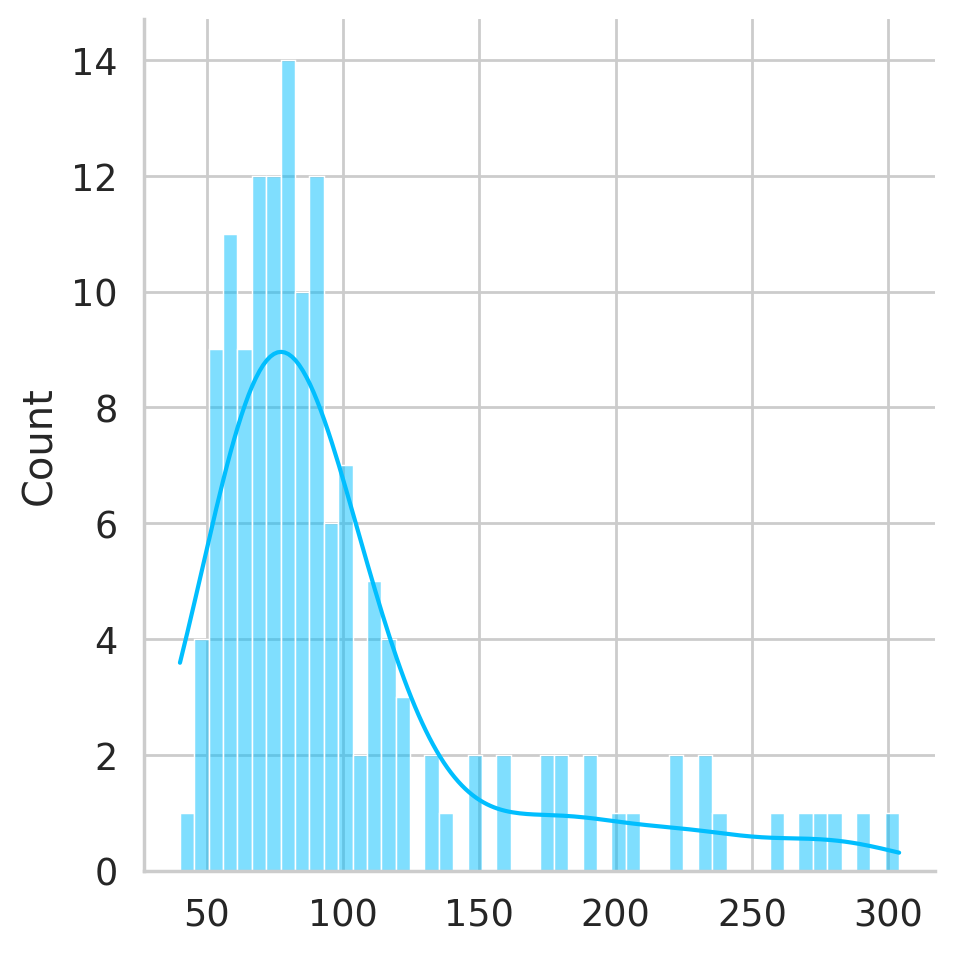

In [15]:
# the test_normal_dataset is the test set where there is only normal data   
predictions, pred_losses = predict(model, test_normal_dataset)
sns.displot(pred_losses, bins=50, kde=True)

# Precision
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')




#### <font color="yellow"> Detect all kind of Anomalies 

In [16]:
from load_data import create_dataset

Correct anomaly predictions: 12838/17262
Accuracy
0.7437145174371452


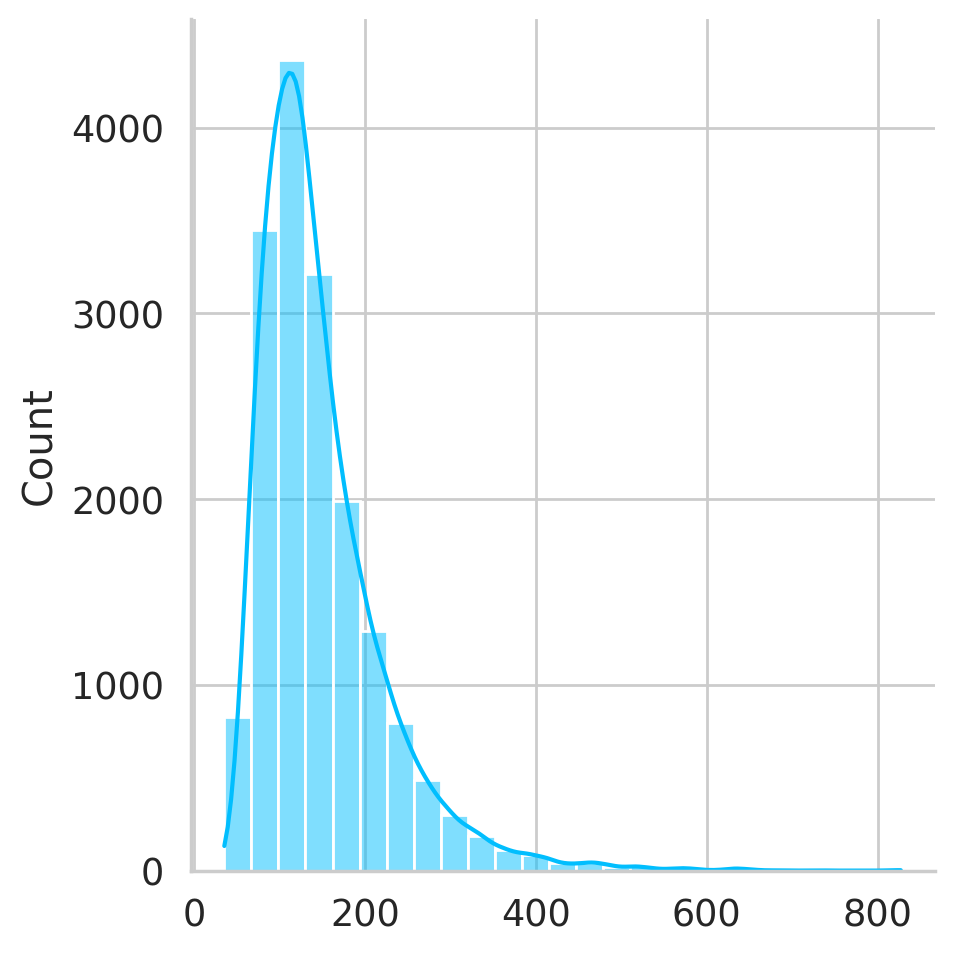

In [17]:
# anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
anomaly_dataset = test_anomaly_dataset
predictions, pred_losses = predict(model, anomaly_dataset)
sns.displot(pred_losses, bins=25, kde=True)

# Precision
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

# Accuracy
print("Accuracy")
print(correct/len(anomaly_dataset))

#### <font color="yellow"> Detect 7^th classes of anomalies

In [19]:
# 'bad_back_round': BBR
# 'bad_innner_thigh': BIT
# 'bad_head': BH
# 'bad_shallow': BS
# 'bad_toe': BT
# 'bad_back_warp': BBW

In [22]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

def predict_anomalies_and_save_hidden_states(model, dataset, label, csv_file_path='hidden_states.csv', device='cpu'):
    predictions, losses = [], []
    hidden_states = []
    criterion = nn.L1Loss(reduction='sum').to(device)
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            
            # Get hidden state from encoder
            hidden_state = model.encoder(seq_true)
            hidden_state_np = hidden_state.cpu().numpy().flatten()
            
            # Append the label to the hidden state
            hidden_state_with_label = np.append(hidden_state_np, label)
            hidden_states.append(hidden_state_with_label)
            
            # Forward pass through the entire autoencoder
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    
    # Save hidden states with labels to a CSV file
    hidden_states_df = pd.DataFrame(hidden_states)
    hidden_states_df.to_csv(csv_file_path, mode='a', index=False, header=False)
    
    return predictions, losses

In [23]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_plot(model, data, key_name, seq_len, batch_size, threshold, csv_file_path='hidden_states.csv', device='cpu'):
    # Create dataset
    test_dataset, seq_len, _ = create_dataset(data[key_name], seq_len)
    
    # Number of sequences
    n_seq = len(test_dataset)
    
    # DataLoader
    test_dataset = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Predictions and losses
    predictions, pred_losses = predict_anomalies_and_save_hidden_states(model, test_dataset, key_name, csv_file_path, device)
    
    # Plot distribution of prediction losses
    sns.displot(pred_losses, bins=50, kde=True)
    plt.title(f'Prediction Loss Distribution for {key_name}')
    plt.xlabel('Prediction Loss')
    plt.ylabel('Density')
    plt.show()
    
    # Precision
    correct = sum(l > threshold for l in pred_losses)
    print(f'Correct anomaly predictions for {key_name}: {correct}/{n_seq}')
    
    # Accuracy
    accuracy = correct / n_seq
    print(f'Accuracy for {key_name}: {accuracy:.4f}')
    
    return accuracy

def evaluate_multiple_classes(model, data, seq_len, batch_size, threshold):
    classes = [k.split(".")[0] for k,v in data.items() if k != "good.csv"]
    
    for key_name in classes:
        print(f'Evaluating class: {key_name}')
        evaluate_and_plot(model, data, key_name, seq_len, batch_size, threshold)
        print("------------------------------------------------------------------")

Evaluating class: bad_back_round
n_seq:  2831
seq_len:  30
n_features:  132
------------------


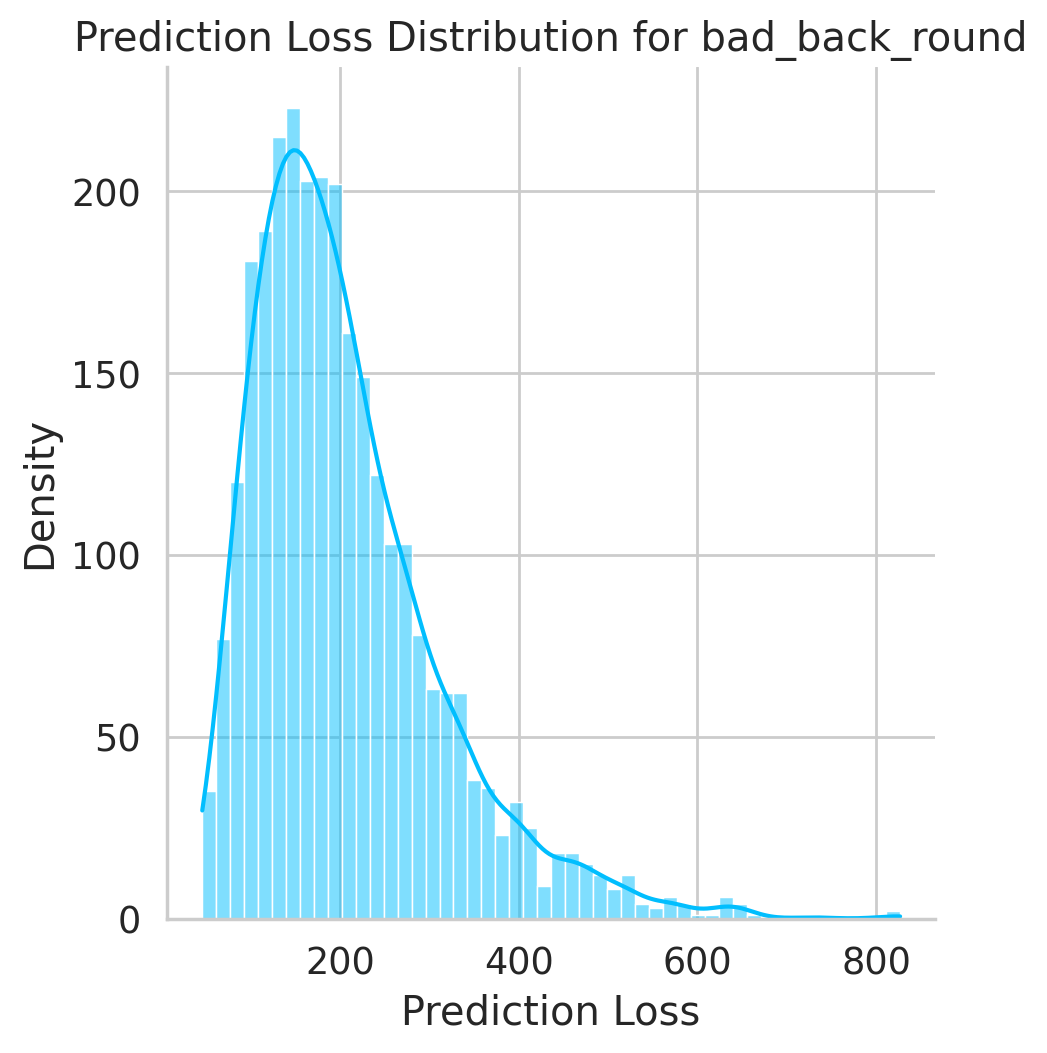

Correct anomaly predictions for bad_back_round: 2518/2831
Accuracy for bad_back_round: 0.8894
------------------------------------------------------------------
Evaluating class: bad_innner_thigh
n_seq:  2321
seq_len:  30
n_features:  132
------------------


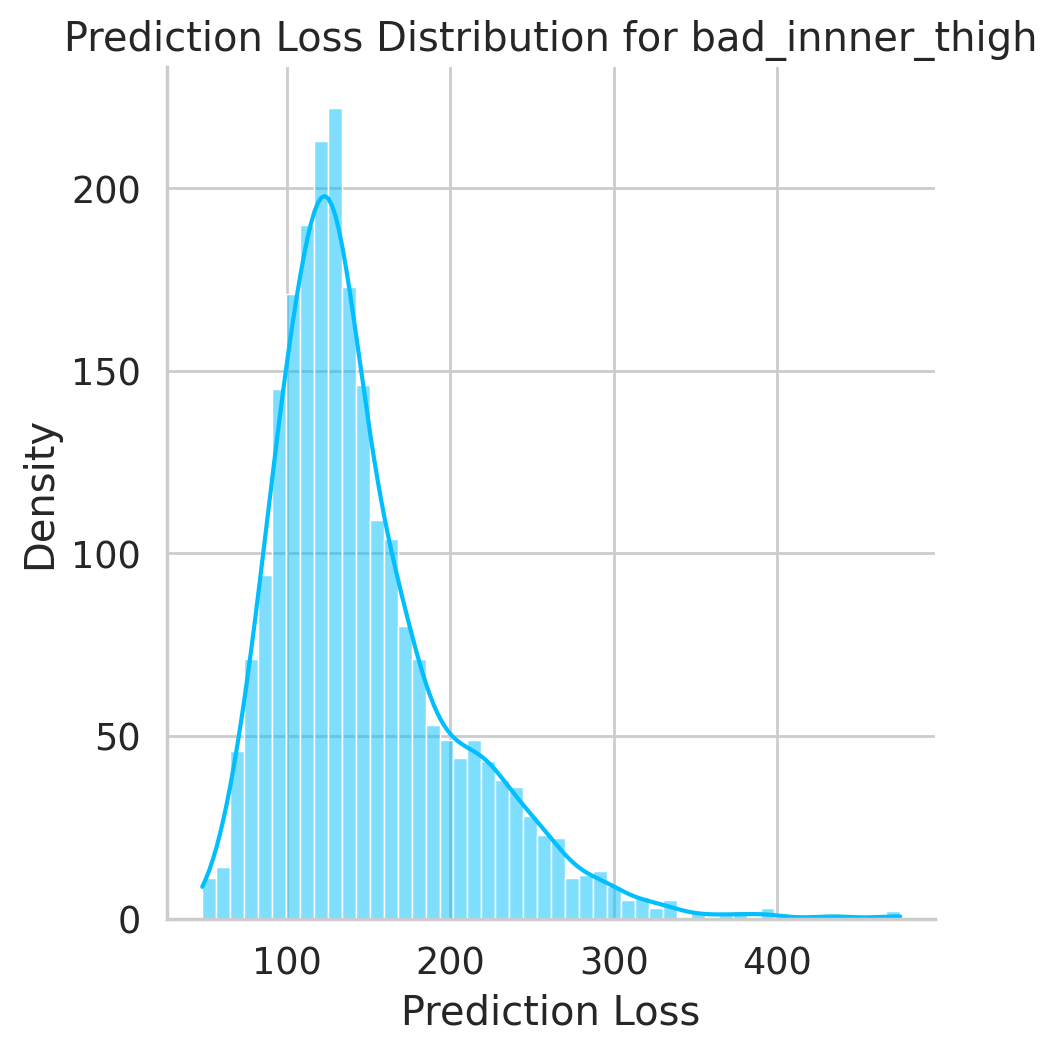

Correct anomaly predictions for bad_innner_thigh: 1927/2321
Accuracy for bad_innner_thigh: 0.8302
------------------------------------------------------------------
Evaluating class: bad_head
n_seq:  2756
seq_len:  30
n_features:  132
------------------


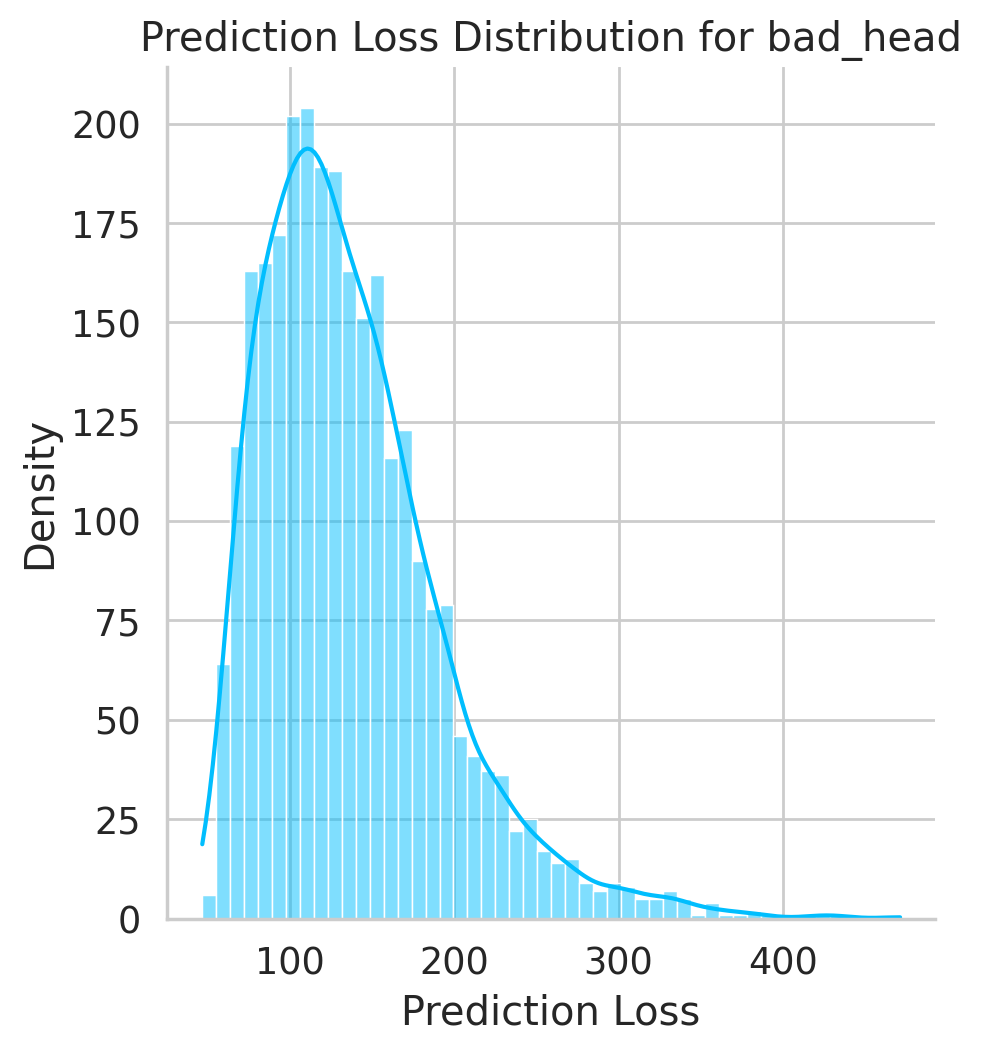

Correct anomaly predictions for bad_head: 2015/2756
Accuracy for bad_head: 0.7311
------------------------------------------------------------------
Evaluating class: bad_shallow
n_seq:  3205
seq_len:  30
n_features:  132
------------------


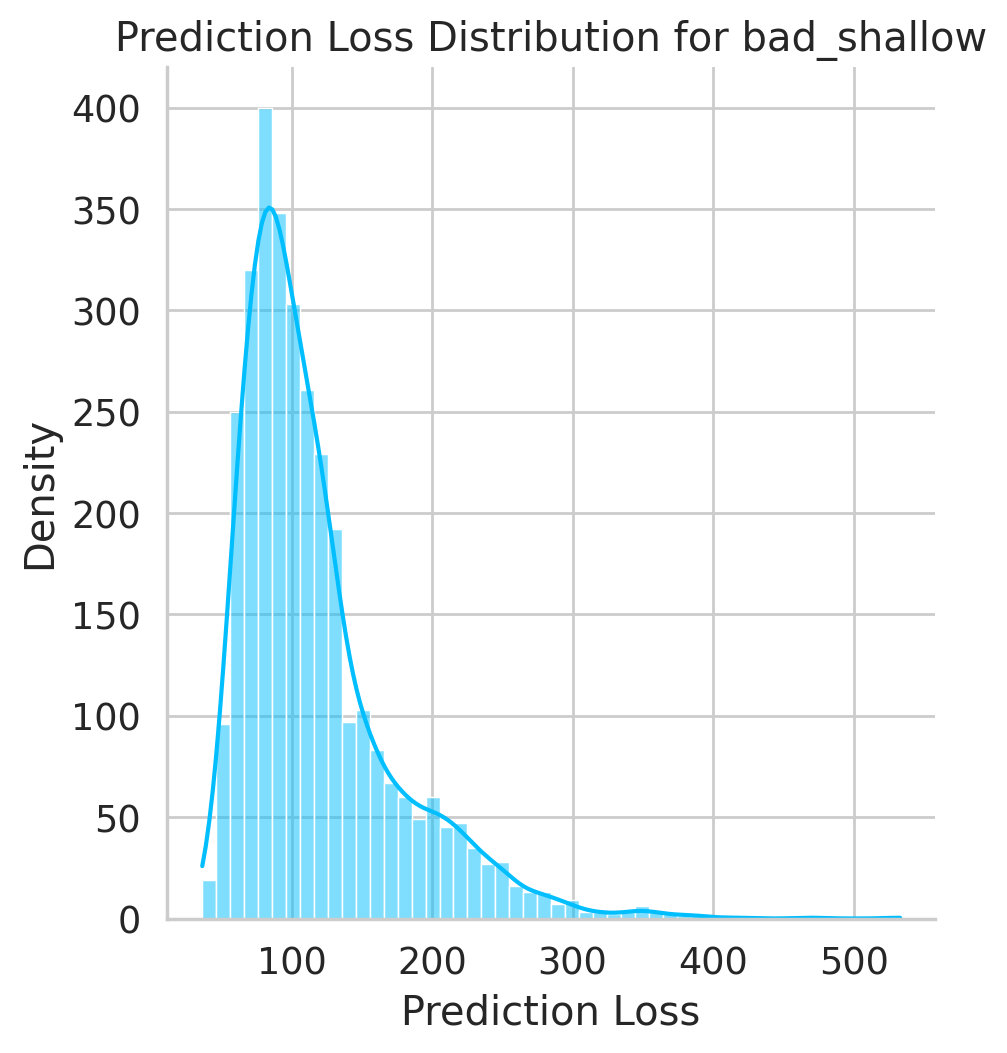

Correct anomaly predictions for bad_shallow: 1659/3205
Accuracy for bad_shallow: 0.5176
------------------------------------------------------------------
Evaluating class: bad_toe
n_seq:  2996
seq_len:  30
n_features:  132
------------------


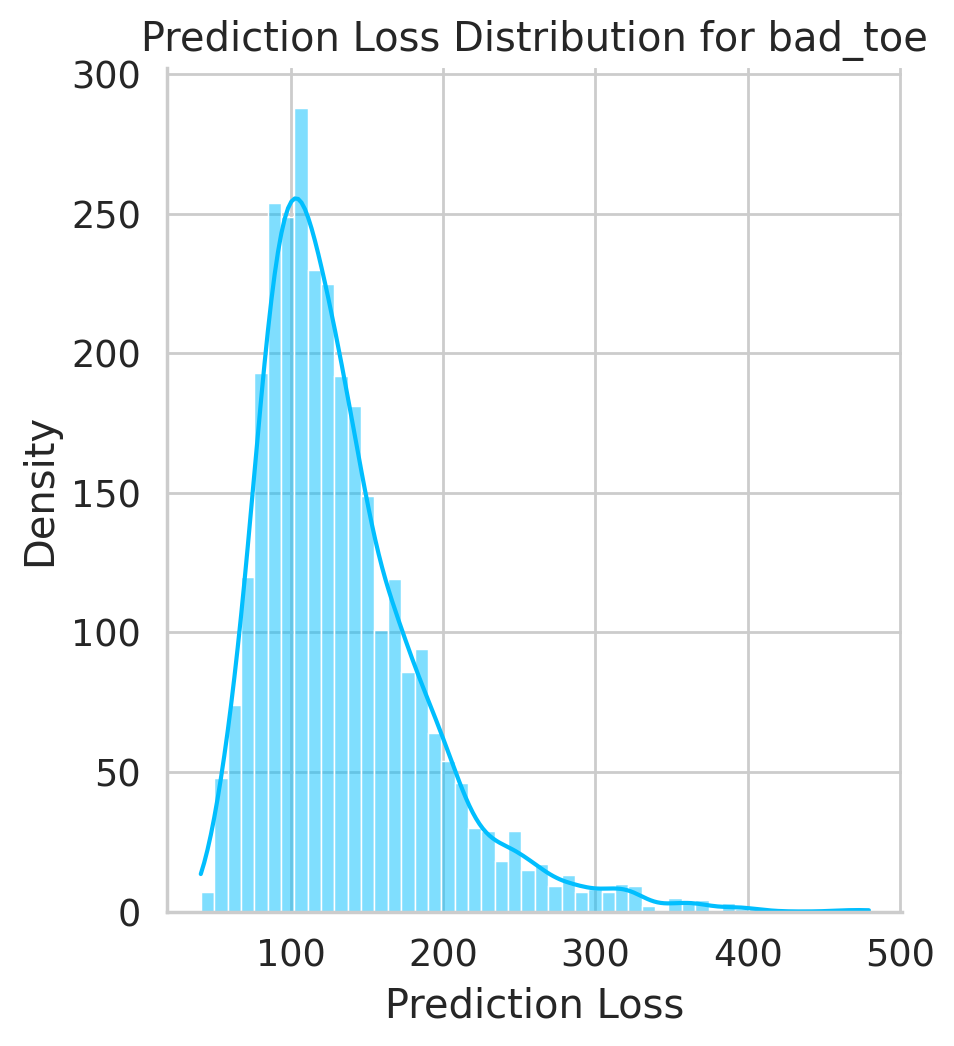

Correct anomaly predictions for bad_toe: 2114/2996
Accuracy for bad_toe: 0.7056
------------------------------------------------------------------
Evaluating class: bad_back_warp
n_seq:  3153
seq_len:  30
n_features:  132
------------------


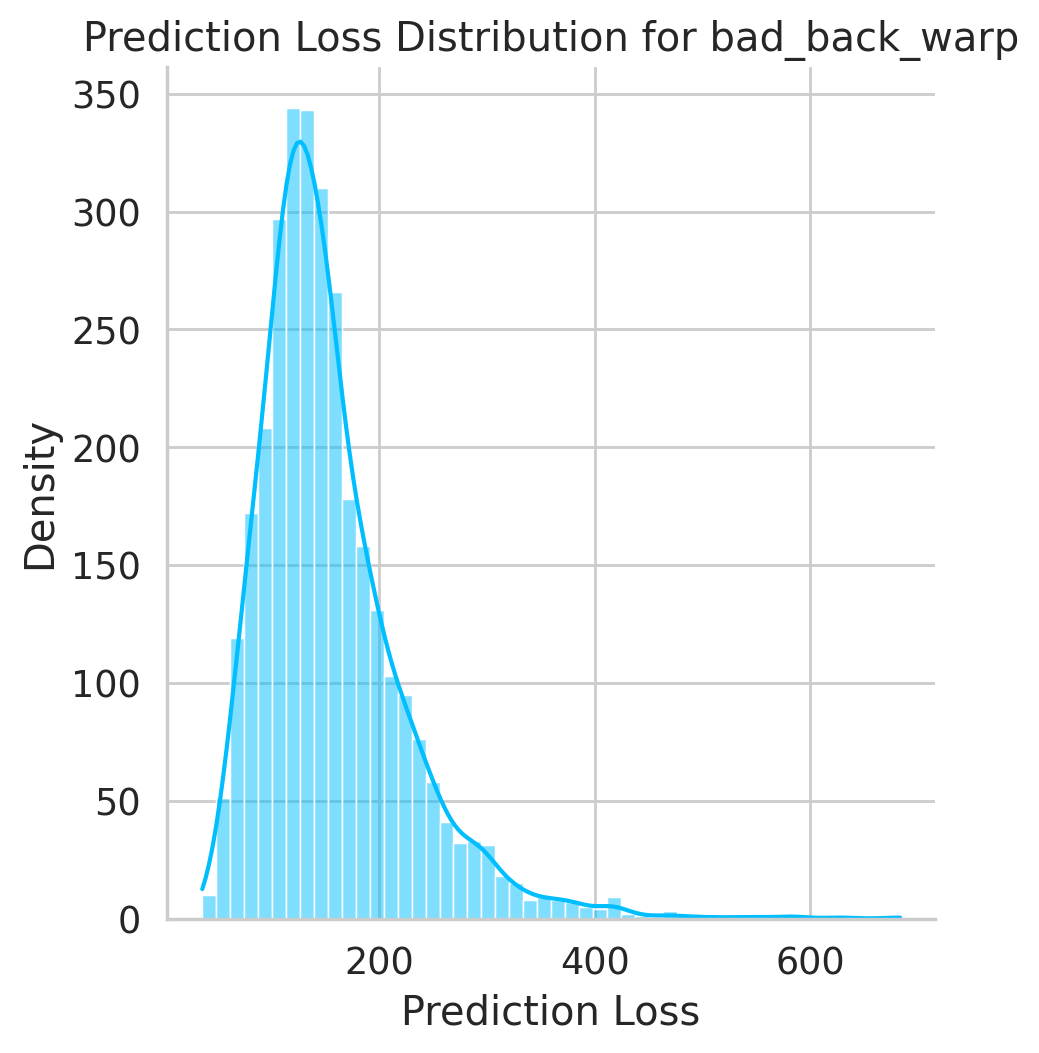

Correct anomaly predictions for bad_back_warp: 2603/3153
Accuracy for bad_back_warp: 0.8256
------------------------------------------------------------------
Evaluating class: good
n_seq:  2965
seq_len:  30
n_features:  132
------------------


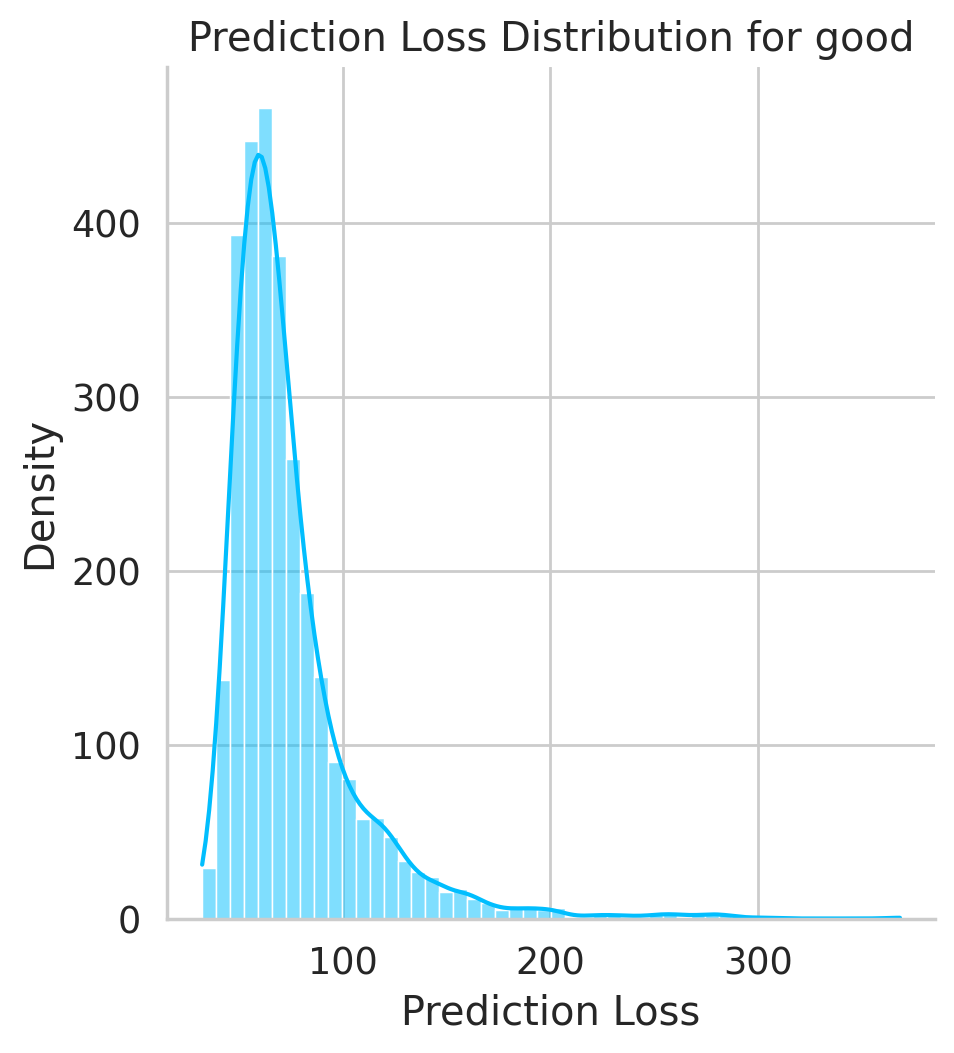

Correct anomaly predictions for good: 423/2965
Accuracy for good: 0.1427
------------------------------------------------------------------


In [24]:
# Assuming `model`, `data`, `seq_len`, `batch_size`, `THRESHOLD`, and `device` are defined
evaluate_multiple_classes(model, data, seq_len, batch_size, THRESHOLD)